In [ ]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# **Load the data of each one of the subjects**

*   The data used in this examples was first preprocessed separately in Matlab using FieldTrip toolbox
*   The correct input shape for tensorflow backend is **(sample_number,sample_size,channel_number)**.
*   Example below uses Subject #1

In [ ]:
import scipy.io as sio
Samples = sio.loadmat('Xtrain_S1_alltrials.mat')
Labels = sio.loadmat('Labels.mat')
X = Samples['Xtrain']
Y = Labels['Y1']

In [ ]:
X = X.swapaxes(0, 2)
Y = Y.swapaxes(0,1)
print(X.shape)
print(Y.shape)

(252, 376, 28)
(252, 1)


In [ ]:
num_classes = 2

In [ ]:
print(num_classes)

2


# **Create a CNN model**

The designed model for this classification was as follows:


*   A 1D convolutional layer with kernel size of 3 yielding 64 filters.
*   A Batch Normalization layer.
*   A ReLu layer.
*   A dropout layer.

This layering order was repeated three times. After this a global average pooling layer gets the average for the channels of each trial. Finally a dense layer acting as a fully connected layer was placed in the CNN architecture with a sigmoig activation function.

For this test, the CNN model was trained using the data from one subject and performing a K-Fold Cross Validation with the same subject data. 

In [ ]:
input_shape =(376,28)
def cnn_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    conv1 = keras.layers.Dropout(.2)(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    conv2 = keras.layers.Dropout(.2)(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)
    conv3 = keras.layers.Dropout(.2)(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(1, activation="sigmoid")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = cnn_model(input_shape=X.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#Define callbacks for the model
epochs = 50
batch_size = 2
callbacks = [
               keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
]
model_checkpoint = keras.callbacks.ModelCheckpoint(
        "Subject_Model.h5", save_best_only=True, monitor="val_loss"
    )
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1)
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy",keras.metrics.TruePositives(name='tp'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalseNegatives(name='fn')]
)  

In [ ]:
#Define a function to fit the model
def fit_and_evaluate(X_train, X_test, Y_train, Y_test, epochs=epochs, batch_size=batch_size):
    model = None
    model = cnn_model(input_shape=X.shape[1:])
    model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy",keras.metrics.TruePositives(name='tp'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalseNegatives(name='fn')]
     )  
    results = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, model_checkpoint], verbose=0, validation_split=0.1)  
    test_loss, test_acc,tp,fp,tn,fn = model.evaluate(X_test, Y_test)
    print(f"Loss:{test_loss} ",f"Acc:{test_acc} ",f"True positives:{tp} ",f"False positives:{fp} ",f"True negatives:{tn} ",f"False negatives:{fn} ")
    return results

In [ ]:
n_folds=10

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(X_train, X_test, Y_train, Y_test, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
2/2 [==============================] - 0s 9ms/step - loss: 0.2435 - accuracy: 0.9412 - tp: 25.0000 - fp: 3.0000 - tn: 23.0000 - fn: 0.0000e+00
Loss:0.2435372918844223  Acc:0.9411764740943909  True positives:25.0  False positives:3.0  True negatives:23.0  False negatives:0.0 


Training on Fold:  2
2/2 [==============================] - 0s 9ms/step - loss: 0.6255 - accuracy: 0.8824 - tp: 22.0000 - fp: 2.0000 - tn: 23.0000 - fn: 4.0000
Loss:0.6255075931549072  Acc:0.8823529481887817  True positives:22.0  False positives:2.0  True negatives:23.0  False negatives:4.0 


Training on Fold:  3
2/2 [==============================] - 0s 9ms/step - loss: 0.5155 - accuracy: 0.9412 - tp: 24.0000 - fp: 2.0000 - tn: 24.0000 - fn: 1.0000
Loss:0.5154647827148438  Acc:0.9411764740943909  True positives:24.0  False positives:2.0  True negatives:24.0  False negatives:1.0 


Training on Fold:  4
2/2 [==============================] - 0s 9ms/step - loss: 0.1975 - accuracy: 0.9608 - tp:

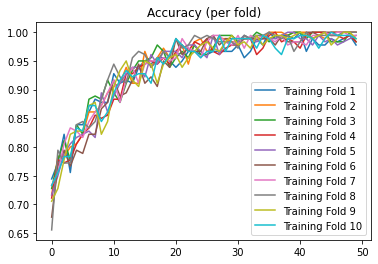

In [ ]:
plt.title('Accuracy (per fold)')
plt.plot(model_history[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['accuracy'], label='Training Fold 3')
plt.plot(model_history[3].history['accuracy'], label='Training Fold 4')
plt.plot(model_history[4].history['accuracy'], label='Training Fold 5')
plt.plot(model_history[5].history['accuracy'], label='Training Fold 6')
plt.plot(model_history[6].history['accuracy'], label='Training Fold 7')
plt.plot(model_history[7].history['accuracy'], label='Training Fold 8')
plt.plot(model_history[8].history['accuracy'], label='Training Fold 9')
plt.plot(model_history[9].history['accuracy'], label='Training Fold 10')
plt.legend()
plt.show()

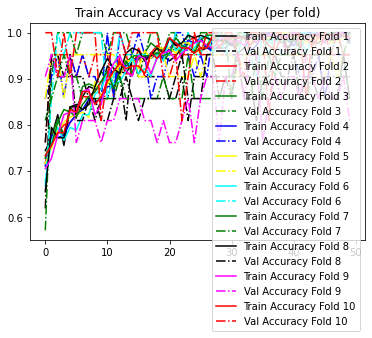

In [ ]:
plt.title('Train Accuracy vs Val Accuracy (per fold)')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.plot(model_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='blue', )
plt.plot(model_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='blue', linestyle = "dashdot")
plt.plot(model_history[4].history['accuracy'], label='Train Accuracy Fold 5', color='yellow', )
plt.plot(model_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='yellow', linestyle = "dashdot")
plt.plot(model_history[5].history['accuracy'], label='Train Accuracy Fold 6', color='cyan', )
plt.plot(model_history[5].history['val_accuracy'], label='Val Accuracy Fold 6', color='cyan', linestyle = "dashdot")
plt.plot(model_history[6].history['accuracy'], label='Train Accuracy Fold 7', color='green', )
plt.plot(model_history[6].history['val_accuracy'], label='Val Accuracy Fold 7', color='green', linestyle = "dashdot")
plt.plot(model_history[7].history['accuracy'], label='Train Accuracy Fold 8', color='black', )
plt.plot(model_history[7].history['val_accuracy'], label='Val Accuracy Fold 8', color='black', linestyle = "dashdot")
plt.plot(model_history[8].history['accuracy'], label='Train Accuracy Fold 9', color='magenta', )
plt.plot(model_history[8].history['val_accuracy'], label='Val Accuracy Fold 9', color='magenta', linestyle = "dashdot")
plt.plot(model_history[9].history['accuracy'], label='Train Accuracy Fold 10', color='red', )
plt.plot(model_history[9].history['val_accuracy'], label='Val Accuracy Fold 10', color='red', linestyle = "dashdot")
plt.legend()
plt.show()